<a href="https://colab.research.google.com/github/gigabyte727/LTD_Hakaton1/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импортируем библиотеки (Добавить в requirements)

In [1]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

# Подготовка набора данных

Расположение набора данных SROIE и имя файла-примера, используемого в демонстрационных целях.

In [2]:
%%bash
echo "Загрузка набора данных"
curl -L "https://github.com/gigabyte727/LTD_Hakaton1/releases/download/v0.1/SROIE2019.zip" -o SROIE2019.zip

Загрузка набора данных


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  833M  100  833M    0     0  5159k      0  0:02:45  0:02:45 --:--:-- 7464k


In [3]:
# Extract data
%%bash
echo "Распаковка датасета"
unzip SROIE2019.zip
echo "Удаление zip-архива"
rm SROIE2019.zip
echo "Готово"

Распаковка датасета
Archive:  SROIE2019.zip
   creating: SROIE2019/
   creating: SROIE2019/layoutlm-base-uncased/
  inflating: SROIE2019/layoutlm-base-uncased/config.json  
  inflating: SROIE2019/layoutlm-base-uncased/pytorch_model.bin  
  inflating: SROIE2019/layoutlm-base-uncased/special_tokens_map.json  
  inflating: SROIE2019/layoutlm-base-uncased/tokenizer_config.json  
  inflating: SROIE2019/layoutlm-base-uncased/training_args.bin  
  inflating: SROIE2019/layoutlm-base-uncased/vocab.txt  
   creating: SROIE2019/test/
   creating: SROIE2019/test/box/
  inflating: SROIE2019/test/box/X00016469670.txt  
  inflating: SROIE2019/test/box/X00016469671.txt  
  inflating: SROIE2019/test/box/X51005200931.txt  
  inflating: SROIE2019/test/box/X51005230605.txt  
  inflating: SROIE2019/test/box/X51005230616.txt  
  inflating: SROIE2019/test/box/X51005230621.txt  
  inflating: SROIE2019/test/box/X51005230648.txt  
  inflating: SROIE2019/test/box/X51005230657.txt  
  inflating: SROIE2019/test/bo

In [4]:
sroie_folder_path = Path('/content/SROIE2019')
example_file = Path("X51005365187.txt")

# Чтение слов и координат границ

Итак, первый шаг — чтение данных OCR, где каждая строка в файле включает группу слов и ограничивающую рамку, которая их определяет. Все, что нам нужно сделать, это прочитать файл, убрать ненужные точки в ограничительной рамке (поскольку модели требуются только верхняя левая и нижняя правая точки) и сохранить его в Pandas Dataframe.

In [5]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # Из разделенной строки сохраняем (имя файла, [точки ограничивающей рамки], текстовая строка).
      # Имя файла пригодится в будущем
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe

# Пример использования

In [6]:
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== Содержимое файла ==")
!head -n 5 "{bbox_file_path}"  # Выводим первые 5 строк датасета

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Содержимое датафрейма ==")
bbox.head(5)

== Содержимое файла ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,


<ipython-input-6-b7b70c414c73>:5: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  bbox = read_bbox_and_words(path=bbox_file_path)



== Содержимое датафрейма ==


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


# Чтение файла сущностей

Теперь нам нужно прочитать файл сущностей, чтобы узнать, что маркировать в нашем тексте.

In [7]:
# Создаем функцию чтения данных в табличном формате
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe

entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== Содержимое файла ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n== Содержимое датафрейма ==")
entities

== Содержимое файла ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}
== Содержимое датафрейма ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


# Присвоение меток словам с использованием данных сущностей

У нас есть наши слова/строки и сущности, теперь нам просто нужно собрать их вместе, пометив наши строки, используя значения сущностей. Мы будем делать это, сопоставляя подстроки значения сущностей со строками, и если они не совпадают, проверим подобия, используя pythons difflib.SequenceMatcher и назначая что-либо выше прогнозируемого совпадения 0,8 (80%).

Метка «О» будет определять все наши слова, не помеченные на этапе присваивания, потому что нам необходимо пометить все.

In [8]:
# Назначаем метку линии, проверив сходство линии и всех сущностей
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Строка:", line)
print("\nСущность:", label)

Строка: F&P PHARMACY

Сущность: COMPANY


С помощью функции, которая может обрабатывать маркировку наших строк, мы создадим другую функцию для маркировки всей нашей строки в одном кадре данных (то есть одной квитанции).

Как бы просто это ни было, проблема возникает, когда мы получаем строки, которые все проходят одно и то же совпадение, например, ИТОГО; в квитанции может быть только один товар, и его цена может совпадать с итоговой суммой, поэтому дублируются этикетки. А может часть адреса тоже присутствует в конце квитанции.

Чтобы игнорировать такие примеры, мы написали простые жестко закодированные правила, чтобы назначать итог и дату только самым большим ограничивающим прямоугольникам, которые он мог найти (в зависимости от его площади), и не позволять назначать адрес после даты или итога.

In [9]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Проходимся по каждой строке словами и назначаем ей метку
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Назначаем наибольшую ограничивающую рамку
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Пример использования
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(5)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS


# Делим слова

В последней части мы разбиваем линии на отдельные токены с их собственными ограничивающими рамками.

Разделение ограничивающих рамок на основе длины слова, вероятно, не самый лучший подход, но он достаточно хорош.

In [10]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Фильтруем нежелательные токены
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Пример использования
new_lines = split_line(bbox_labeled.loc[1])
print("Оригинальная строка:")
display(bbox_labeled.loc[1:1,:])

print("\nРазделенная строка:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Оригинальная строка:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY



Разделенная строка:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


# Собираем все вместе

Мы определили все наши функции, теперь нам просто нужно использовать их для каждого файла и преобразовать набор данных в формат, который может анализировать скрипт/модель.

In [11]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Сортируем по имени файла, чтобы при сжатии их вместе
  # мы не получили какой-то другой файл (на всякий случай)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Чтение датасета:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Читаем файлы
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Назначаем метки строкам в bbox с помощью сущностей
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Разделяем строки на отдельные токены
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Выполняем другое назначение меток, чтобы маркировка была более точной.
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

Поскольку в наборе данных есть две папки, одна предназначена для обучения модели, а другая для тестирования ее производительности, мы можем использовать один и тот же скрипт, чтобы прочитать их обе и сохранить их в соответствующих переменных.

In [12]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')
print('\nВыполнено')

Чтение датасета:


  0%|          | 0/626 [00:00<?, ?it/s]<ipython-input-11-57f1ed0efd3b>:18: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  bbox = read_bbox_and_words(bbox_file)
<ipython-input-12-0cbbef07b00c>:1: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  dataset_train = dataset_creator(sroie_folder_path / 'train')
100%|██████████| 626/626 [01:07<00:00,  9.22it/s]


Чтение датасета:


  0%|          | 0/347 [00:00<?, ?it/s]<ipython-input-12-0cbbef07b00c>:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  dataset_test = dataset_creator(sroie_folder_path / 'test')
100%|██████████| 347/347 [00:37<00:00,  9.34it/s]


Выполнено


In [13]:
exmpl = dataset_train[1]
exmpl

[         filename   x0   y0   x2   y2       line      label
 0    X00016469619   76   50  133   84        TAN          O
 1    X00016469619  138   50  214   84       WOON          O
 2    X00016469619  219   50  295   84       YANN          O
 3    X00016469619  110  165  156  188      INDAH  S-COMPANY
 4    X00016469619  161  165  198  188       GIFT  S-COMPANY
 ..            ...  ...  ...  ...  ...        ...        ...
 97   X00016469619   62  940  127  958    DEALING          O
 98   X00016469619  132  940  150  958         IN          O
 99   X00016469619  155  940  239  958  WHOLESALE          O
 100  X00016469619  244  940  272  958        AND          O
 101  X00016469619  277  940  342  958    RETAIL.          O
 
 [102 rows x 7 columns], 439, 1004]

# Запись преобразованного набора данных

Теперь, когда мы преобразовали наш набор данных в формат, понятный модели для обучения, нам нужно сохранить все в файлы.

Мы будем использовать одну и ту же функцию для записи в файлы train и test.

Функция нормализации предназначена для нормализации точек ограничивающих рамок в диапазоне [0,1000] с использованием ширины и высоты изображения квитанции [источник.](http://huggingface.co/docs/transformers/model_doc/layoutlm#overview)

In [14]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Проходимся по каждому набору данных
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Пройдем через каждую строку в наборе данных
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Напишем вторую новую строку, чтобы отделить набор данных от других
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [15]:
dataset_directory = Path('/content/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Создаем файл labels.txt для модели, какие категории будет предсказывать.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Пишем в последней метке O - предназначено для всех немаркированных слов
  f.write("O")

Writing training dataset:


100%|██████████| 626/626 [00:28<00:00, 21.78it/s]


Writing testing dataset:


100%|██████████| 347/347 [00:16<00:00, 21.68it/s]


# Тонкая настройка LayoutLM

Мы загрузили и преобразовали наш набор данных в обучаемый и тестируемый набор, теперь мы можем приступить к тонкой настройке модели.

## Скачать модель

Сначала мы клонируем проект LayoutLM Github, который содержит скрипт для тонкой настройки нашей модели.

In [16]:
%%bash
git clone https://github.com/microsoft/unilm.git
cd unilm/layoutlm/deprecated
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/unilm/layoutlm/deprecated
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/195.7 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s e

Cloning into 'unilm'...


# Обучение

In [17]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased')

pretrained_model_folder=Path('/content/SROIE2019/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Переходим в каталог скрипта
os.chdir("/content/unilm/layoutlm/deprecated/examples/seq_labeling")

Сначала мы копируем предварительно обученную базовую модель в наш рабочий каталог, чтобы изменить ее файл конфигурации. Мы просто меняем количество Head Attention с 16 на 12, потому что это исходный размер.

In [18]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

cp: cannot copy a directory, '/content/SROIE2019/layoutlm-base-uncased', into itself, '/content/SROIE2019/layoutlm-base-uncased/layoutlm-base-uncased'


In [19]:
! cat "/content/SROIE2019/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [20]:
! rm -rf /content/working/dataset/cached*

In [21]:
print(os.getcwd())

/content/unilm/layoutlm/deprecated/examples/seq_labeling


# Прогнозирование

In [26]:
! python run_seq_labeling.py \
                            --data_dir /content/working/dataset \
                            --labels /content/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --max_seq_length 512 \
                            --do_lower_case \
                            --do_train \
                            --num_train_epochs 10 \
                            --logging_steps 1 \
                            --save_steps -1 \
                            --output_dir output \
                            --overwrite_output_dir \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 16

Epoch:   0% 0/10 [00:00<?, ?it/s]
Iteration:   0% 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:257: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Iteration:   1% 1/79 [00:03<04:29,  3.46s/it]
Iteration:   3% 2/79 [00:04<02:22,  1.85s/it]
Iteration:   4% 3/79 [00:04<01:41,  1.33s/it]
Iteration:   5% 4/79 [00:05<01:21,  1.09s/it]
Iteration:   6% 5/79 [00:06<01:10,  1.04it/s]
Iteration:   8% 6/79 [00:07<01:04,  1.14it/s]
Iteration:   9% 7/79 [00:07<00:59,  

In [27]:
# Оцениваем тестовый набор и сделаем прогнозы
! python run_seq_labeling.py \
                            --data_dir /content/working/dataset \
                            --labels /content/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

Evaluating: 100% 44/44 [00:11<00:00,  3.94it/s]


In [28]:
!cat /output/test_results.txt

cat: /output/test_results.txt: No such file or directory


# Образец результата

В примере показаны два расположенных рядом изображения одной и той же квитанции, где цветные прямоугольники представляют собой помеченные линии. Слева — оригинал, поэтому данные мы пометили, а справа — прогноз модели.

In [29]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv("/content/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/content/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [30]:

# Функция результата предсказания
def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)
  print(image_path)
  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Это пример, когда наша предварительная обработка не была идеальной, но модель все же предсказывала правильный результат. Из этого мы видим, что если бы наша предварительная обработка была лучше, у модели был бы лучший показатель точности.

Filename: X00016469670.jpg
/content/SROIE2019/test/img/X00016469670.jpg


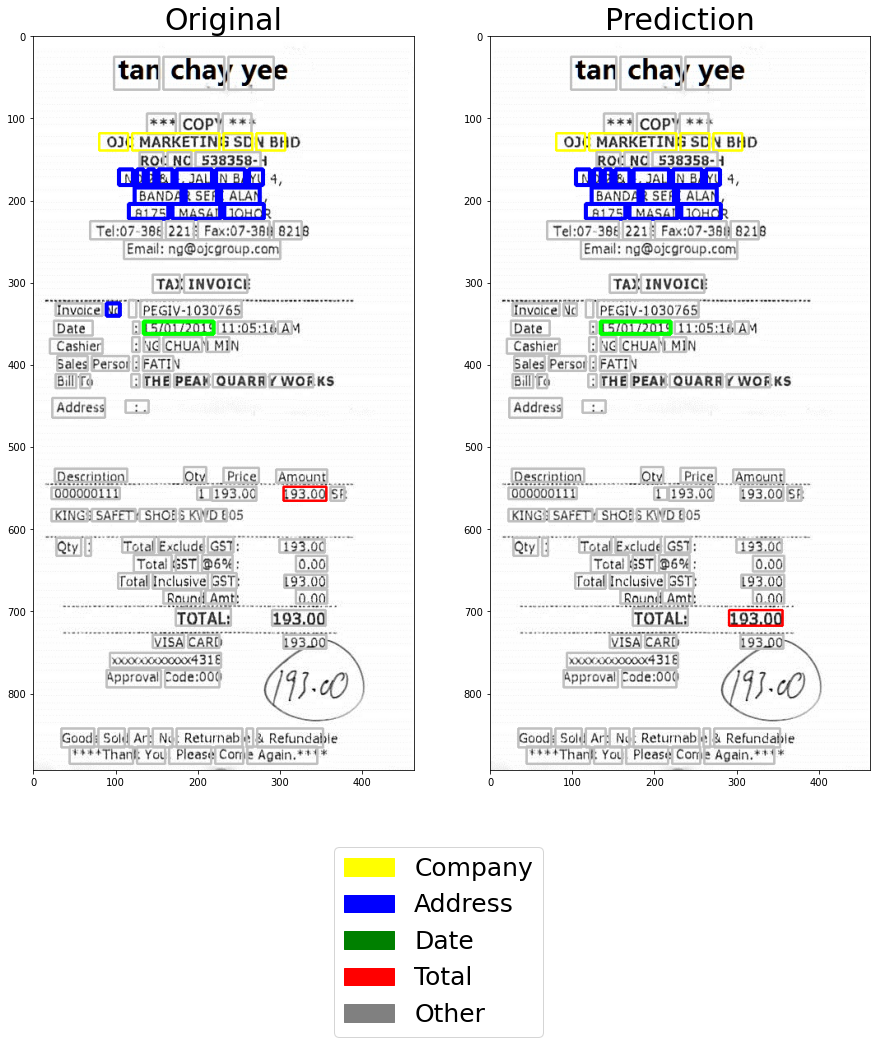

In [31]:
display_prediction(merged_groups[0], 'test')

Filename: X51005268408.jpg
/content/SROIE2019/test/img/X51005268408.jpg


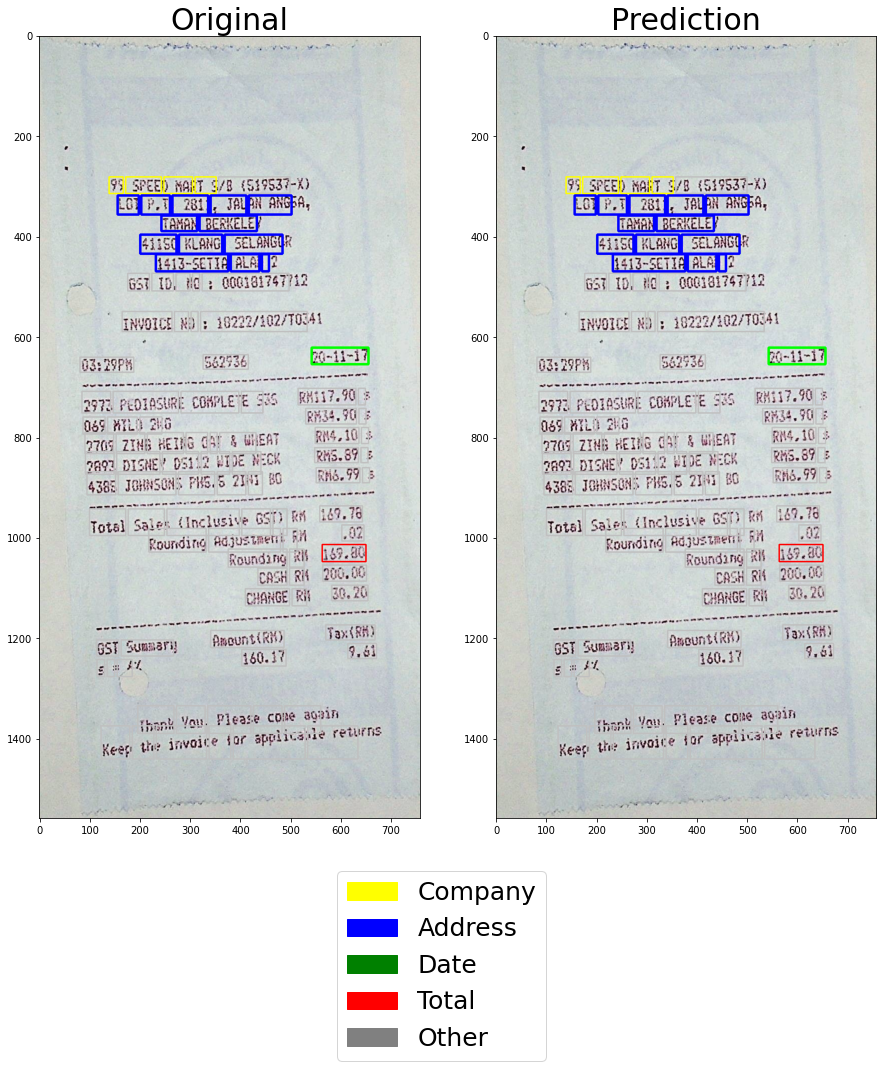

In [32]:
display_prediction(merged_groups[10], 'test')

Filename: X51005433518.jpg
/content/SROIE2019/test/img/X51005433518.jpg


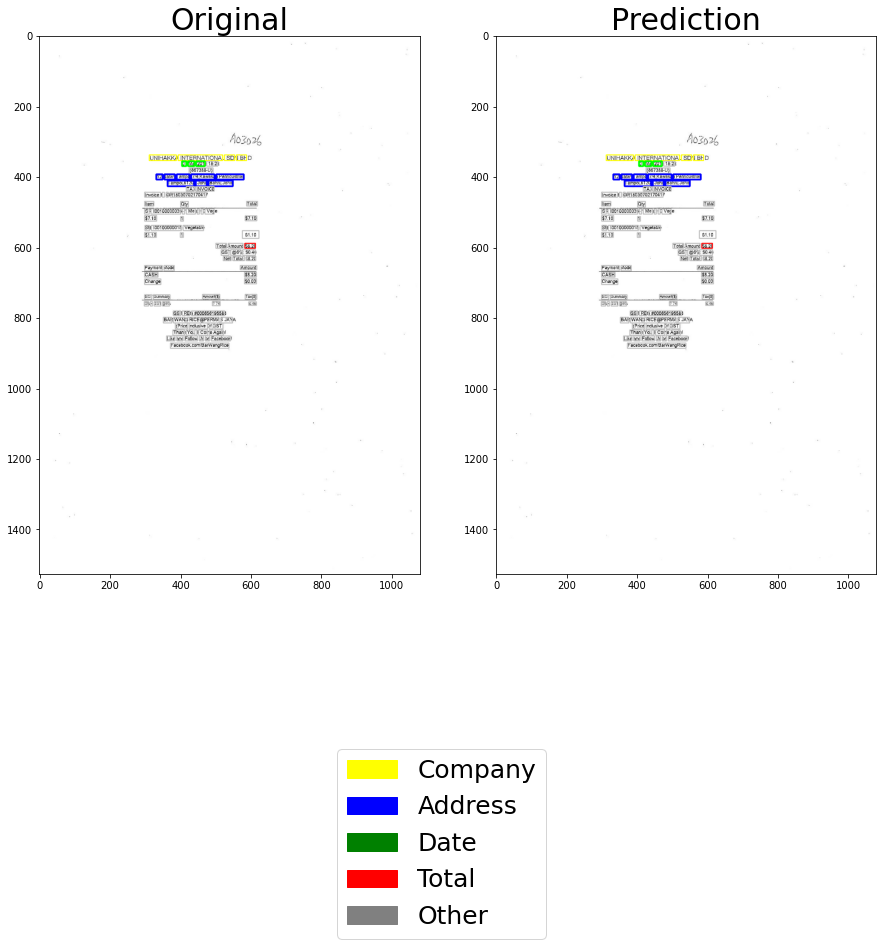

In [33]:
display_prediction(merged_groups[20], 'test')

Filename: X51005621482.jpg
/content/SROIE2019/test/img/X51005621482.jpg


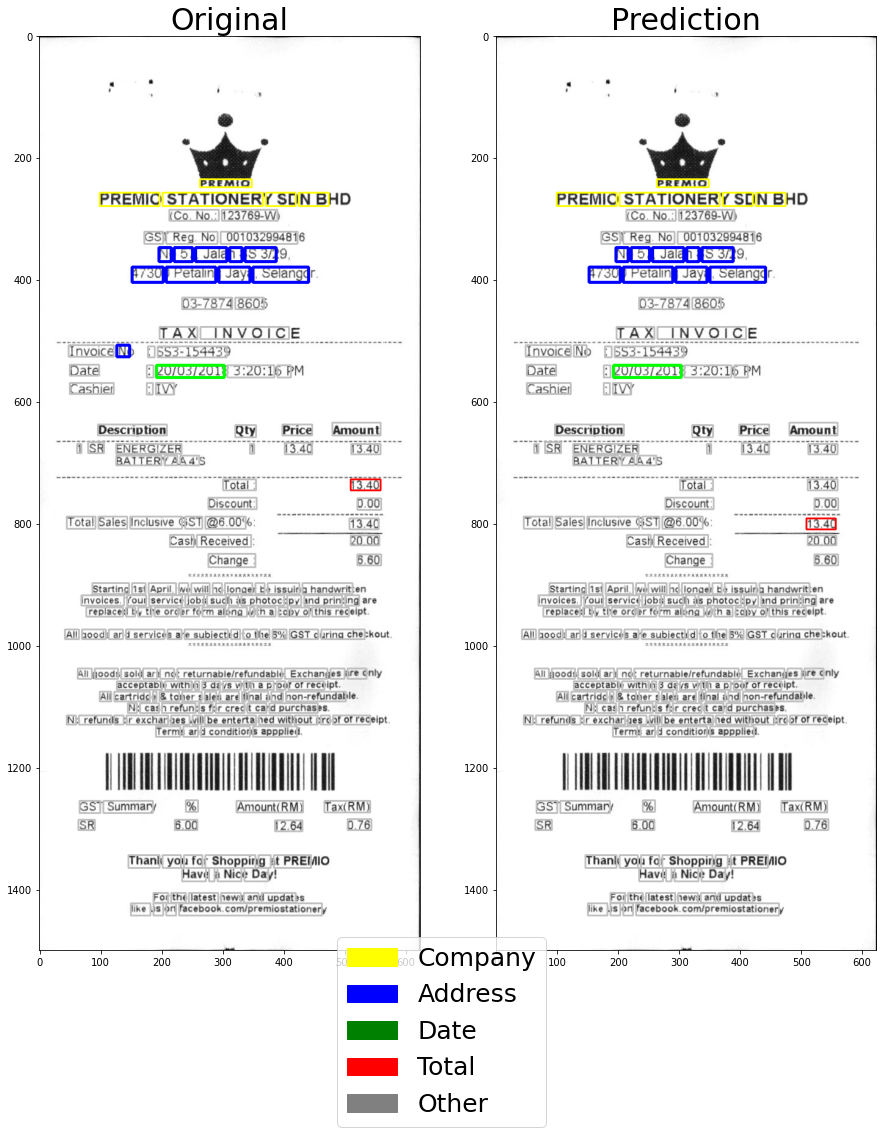

In [34]:
display_prediction(merged_groups[55], 'test')

Filename: X51006334742.jpg
/content/SROIE2019/test/img/X51006334742.jpg


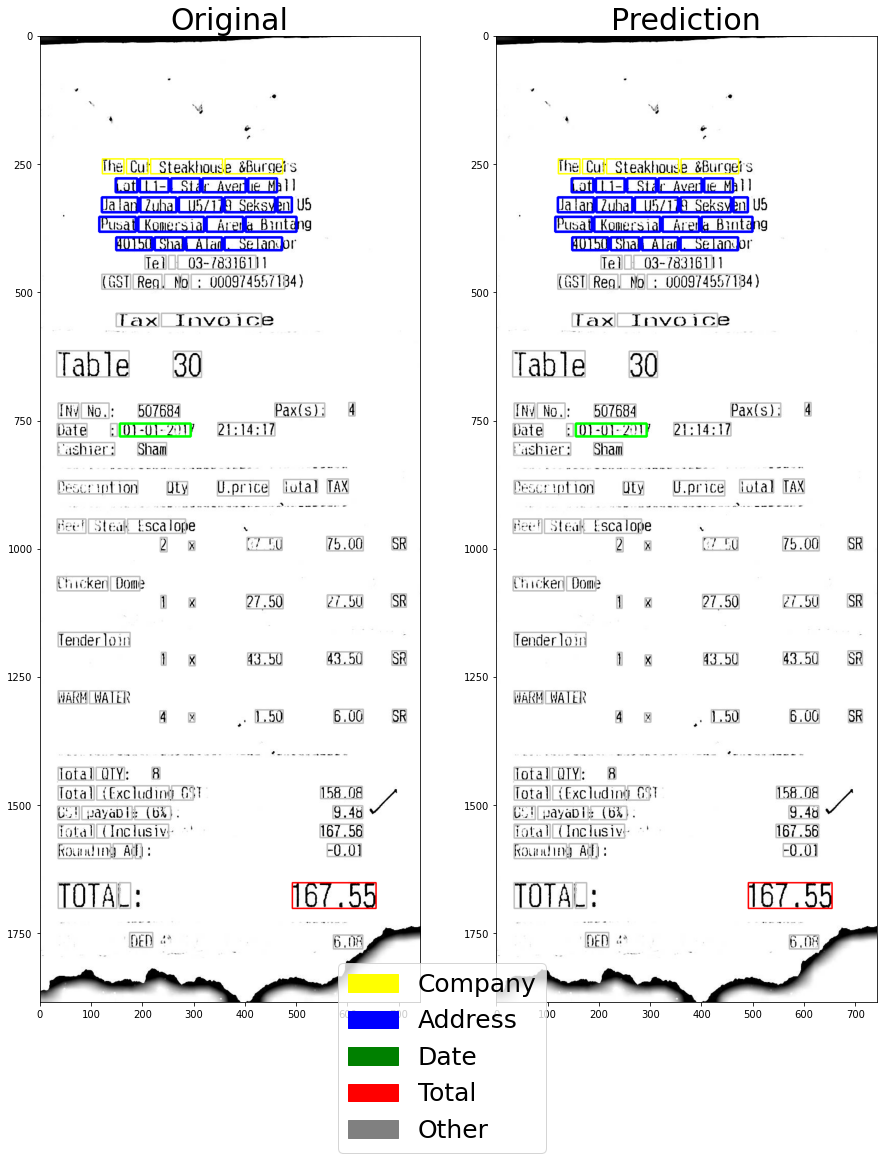

In [35]:
display_prediction(merged_groups[154], 'test')

Filename: X51006620437.jpg
/content/SROIE2019/test/img/X51006620437.jpg


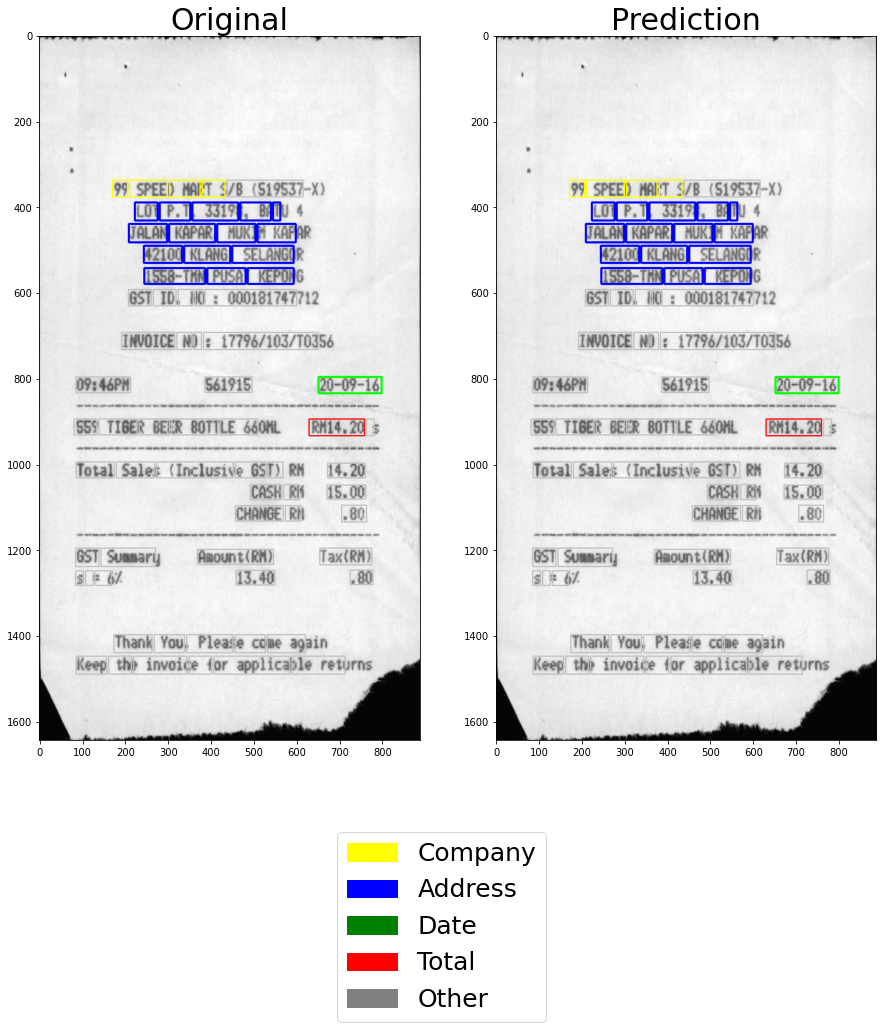

In [36]:
display_prediction(merged_groups[254], 'test')

In [37]:
df = merged_groups[2][1]
df.head()

,name,bbox,size,image,true_category,prediction_category
205,PERNIAGAAN,380 241 498 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
206,ZHENG,503 241 562 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
207,HUI,567 241 602 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
208,JM0326955-V,459 267 546 282,992 1403,X51005200931,O,O
209,NO.59,416 286 454 301,992 1403,X51005200931,S-ADDRESS,S-ADDRESS


In [38]:
df1 = df.drop(['size','image','true_category'], axis = 1)
print(df1)

            name               bbox prediction_category
205   PERNIAGAAN    380 241 498 266           S-COMPANY
206        ZHENG    503 241 562 266           S-COMPANY
207          HUI    567 241 602 266           S-COMPANY
208  JM0326955-V    459 267 546 282                   O
209        NO.59    416 286 454 301           S-ADDRESS
..           ...                ...                 ...
350          ARE  451 1136 477 1155                   O
351          NOT  482 1136 508 1155                   O
352   RETURNABLE  513 1136 602 1155                   O
353        THANK  450 1160 490 1175                   O
354         YOU.  495 1160 527 1175                   O

[150 rows x 3 columns]


In [39]:
csv_data = df1.to_csv()
print(csv_data)

,name,bbox,prediction_category
205,PERNIAGAAN,380 241 498 266,S-COMPANY
206,ZHENG,503 241 562 266,S-COMPANY
207,HUI,567 241 602 266,S-COMPANY
208,JM0326955-V,459 267 546 282,O
209,NO.59,416 286 454 301,S-ADDRESS
210,JALAN,459 286 497 301,S-ADDRESS
211,PERMAS,502 286 548 301,S-ADDRESS
212,9/5,553 286 576 301,S-ADDRESS
213,BANDAR,404 304 455 320,S-ADDRESS
214,BARU,460 304 494 320,S-ADDRESS
215,PERMAS,499 304 550 320,S-ADDRESS
216,JAYA,555 304 589 320,S-ADDRESS
217,81750,427 319 471 338,S-ADDRESS
218,JOHOR,476 319 520 338,S-ADDRESS
219,BAHRU,525 319 569 338,S-ADDRESS
220,TEL:07-386,386 337 467 353,O
221,7524,472 337 504 353,O
222,FAX:07-386,509 337 590 353,O
223,3793,595 337 627 353,O
224,GST,436 361 459 376,O
225,NO:,464 361 487 376,O
226,000800689824,492 361 585 376,O
227,SIMPLIFIED,422 389 504 405,O
228,TAX,509 389 533 405,O
229,INVOICE,538 389 595 405,O
230,GOGIANT,332 417 389 431,O
231,ENGINEERING,394 417 484 431,O
232,(M),489 417 513 431,O
233,SDN,518 417 542 431,O
234,BHD,547 417 5

In [40]:
# Возвращаем рабочий каталог
import os
dire = os.getcwd()
print(dire)
%cd unilm/layoutlm/deprecated/examples/seq_labeling
!ls

/content/unilm/layoutlm/deprecated/examples/seq_labeling
[Errno 2] No such file or directory: 'unilm/layoutlm/deprecated/examples/seq_labeling'
/content
output	prediction.jpg	preprocess.py  preprocess.sh  runs  run_seq_labeling.py
